In [242]:
from __future__ import print_function
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
import keras
from tensorflow.keras import layers

from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


In [243]:
keras.__version__

'2.2.4'

In [244]:
! ls

aa.ipynb		 equipment_success.csv	       mlcc-exercises_en.zip
demo.ipynb		 equipment_success_unique.csv
equipment-success.ipynb  mlcc-exercises


In [245]:

equipment_success_dataframe = pd.read_csv("./equipment_success_unique.csv", sep=",")

equipment_success_dataframe['decades_old'] = round(equipment_success_dataframe['age_in_months_at_equipped_start'] / 120)

def isMale(x):
    if x == "male":
        return 1
    return 0
def isFemale(x):
    if x == "female":
        return 1
    return 0
def isRightEar(x):
    if x == "R":
        return 1
    return 0
def isLeftEar(x):
    if x == "L":
        return 1
    return 0
def isBothEars(x):
    if x == "BIN":
        return 1
    return 0
def dbToAmp (x):
    return 10**(x/20)


equipment_success_dataframe['isMale'] = equipment_success_dataframe['gender'].apply(isMale)
equipment_success_dataframe['isFemale'] = equipment_success_dataframe['gender'].apply(isFemale)
equipment_success_dataframe['isRightEar'] = equipment_success_dataframe['ears'].apply(isRightEar)
equipment_success_dataframe['isLeftEar'] = equipment_success_dataframe['ears'].apply(isLeftEar)
equipment_success_dataframe['isBothEars'] = equipment_success_dataframe['ears'].apply(isBothEars)


equipment_success_dataframe['freq_500_over_freq_1000'] = equipment_success_dataframe['freq_500']/equipment_success_dataframe['freq_1000']
equipment_success_dataframe['freq_2000_over_freq_1000'] = equipment_success_dataframe['freq_2000']/equipment_success_dataframe['freq_1000']
equipment_success_dataframe['freq_4000_over_freq_1000'] = equipment_success_dataframe['freq_4000']/equipment_success_dataframe['freq_1000']


equipment_success_dataframe['freq_500_gain'] = equipment_success_dataframe['freq_500'] - equipment_success_dataframe['eq_freq_500']
equipment_success_dataframe['freq_1000_gain'] = equipment_success_dataframe['freq_1000'] - equipment_success_dataframe['eq_freq_1000']
equipment_success_dataframe['freq_2000_gain'] = equipment_success_dataframe['freq_2000'] - equipment_success_dataframe['eq_freq_2000']
equipment_success_dataframe['freq_4000_gain'] = equipment_success_dataframe['freq_4000'] - equipment_success_dataframe['eq_freq_4000']

equipment_success_dataframe['freq_500_gain_ratio'] = equipment_success_dataframe['freq_500_gain'] / equipment_success_dataframe['freq_500']
equipment_success_dataframe['freq_1000_gain_ratio'] = equipment_success_dataframe['freq_1000_gain'] / equipment_success_dataframe['freq_1000']
equipment_success_dataframe['freq_2000_gain_ratio'] = equipment_success_dataframe['freq_2000_gain'] / equipment_success_dataframe['freq_2000']
equipment_success_dataframe['freq_4000_gain_ratio'] = equipment_success_dataframe['freq_4000_gain'] / equipment_success_dataframe['freq_4000']

# equipment_success_dataframe['eq_gain_ratio'] = (-equipment_success_dataframe['eq_average_loss'] + equipment_success_dataframe['average_loss'])/equipment_success_dataframe['average_loss']


equipment_success_dataframe = equipment_success_dataframe.drop(columns=["eq_average_loss", "eq_high_loss", "eq_low_loss", "rk", "ears", "gender"])



In [246]:
equipment_success_dataframe['valid'] = (
    equipment_success_dataframe['freq_500'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['freq_1000'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['freq_2000'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['freq_4000'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['eq_freq_500'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['eq_freq_1000'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['eq_freq_2000'].apply(lambda x : not math.isnan(x)) &
    equipment_success_dataframe['eq_freq_4000'].apply(lambda x : not math.isnan(x)) &
    
    equipment_success_dataframe['freq_500_gain'].apply(lambda x : not math.isnan(x) and x > 0) &
    equipment_success_dataframe['freq_1000_gain'].apply(lambda x : not math.isnan(x) and x > 0) &
    equipment_success_dataframe['freq_2000_gain'].apply(lambda x : not math.isnan(x) and x > 0) &
    equipment_success_dataframe['freq_4000_gain'].apply(lambda x : not math.isnan(x) and x > 0) &

    equipment_success_dataframe['freq_500_gain_ratio'].apply(lambda x : not math.isnan(x) and x < 1) &
    equipment_success_dataframe['freq_1000_gain_ratio'].apply(lambda x : not math.isnan(x) and x < 1) &
    equipment_success_dataframe['freq_2000_gain_ratio'].apply(lambda x : not math.isnan(x) and x < 1) &
    equipment_success_dataframe['freq_4000_gain_ratio'].apply(lambda x : not math.isnan(x) and x < 1) &
    
    equipment_success_dataframe['isBothEars'].apply(lambda x : x == 0) &
        equipment_success_dataframe['isMale'].apply(lambda x : x == 1) &

    equipment_success_dataframe['months_since_equipped'].apply(lambda x : x > 12) &
    equipment_success_dataframe['decades_old'].apply(lambda x : 2 < x < 10) 

)

In [247]:
equipment_success_valid = equipment_success_dataframe.query(' valid == True').copy()

equipment_success_valid

,patient_id,center_id,months_since_equipped,average_loss,high_loss,low_loss,id,age_in_months_at_equipped_start,freq_500,freq_1000,...,freq_4000_over_freq_1000,freq_500_gain,freq_1000_gain,freq_2000_gain,freq_4000_gain,freq_500_gain_ratio,freq_1000_gain_ratio,freq_2000_gain_ratio,freq_4000_gain_ratio,valid
49,929,72,15,40.0,40.0,38.8,1254588,537.0,40.0,40.0,...,1.0,20.0,20.0,15.0,10.0,0.5,0.5,0.4,0.2,True
50,929,72,15,50.0,50.7,48.8,1254688,537.0,50.0,50.0,...,1.0,20.0,15.0,10.0,15.0,0.4,0.3,0.2,0.3,True
68,975,56,32,47.5,55.0,45.0,1267411,683.0,50.0,35.0,...,1.9,10.0,15.0,15.0,15.0,0.2,0.4,0.4,0.2,True
96,1039,66,97,55.0,62.9,44.0,1178033,924.0,45.0,50.0,...,1.5,15.0,10.0,20.0,25.0,0.3,0.2,0.4,0.3,True
128,1133,87,37,60.0,77.1,42.0,1155167,1013.0,40.0,55.0,...,1.5,10.0,30.0,35.0,20.0,0.2,0.5,0.5,0.2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86048,288003,1289,23,55.0,65.7,45.0,1250281,1065.0,45.0,50.0,...,1.3,10.0,15.0,20.0,15.0,0.2,0.3,0.3,0.2,True
86095,288188,29,47,56.2,61.7,40.0,1215108,683.0,40.0,50.0,...,1.5,10.0,25.0,25.0,5.0,0.2,0.5,0.4,0.1,True
86096,288188,29,47,53.8,60.0,38.3,1218008,683.0,35.0,50.0,...,1.4,10.0,25.0,25.0,5.0,0.3,0.5,0.4,0.1,True
86132,288373,66,79,63.8,73.6,59.0,1175659,726.0,55.0,60.0,...,1.2,25.0,35.0,45.0,35.0,0.5,0.6,0.6,0.5,True


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7959636940>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f795944c1d0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7959470ac8>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f79595e5400>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7959589be0>]],
      dtype=object)

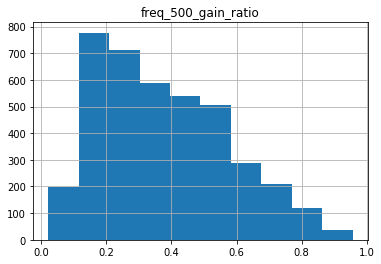

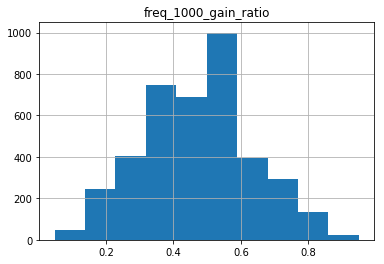

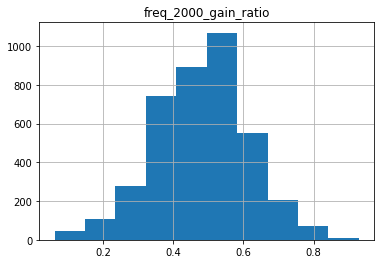

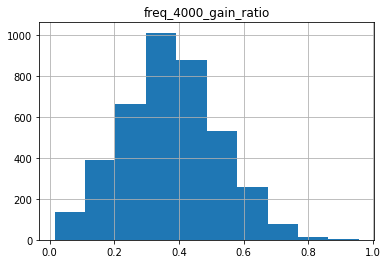

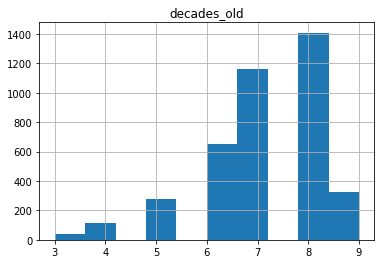

In [248]:
for feature in ['freq_500_gain_ratio', 'freq_1000_gain_ratio', 'freq_2000_gain_ratio', 'freq_4000_gain_ratio', 'decades_old']:
    display.display(equipment_success_valid.hist(feature))

In [249]:
def scaleInner(df, feature):
    stats = df[feature].describe();
    std = stats['std']
    mean = stats['mean']
    df[feature + '_scaled'] = (df[feature] - mean)/std
    return df

def scale(df, features):
    scaledDf = df.copy()
    for feature in features:
        scaleInner(scaledDf, feature)
    return scaledDf        

In [250]:
def success_ratio(equipment_success, freq, multiplier, threshold ):
    data = pd.value_counts(
        equipment_success['freq_' + freq + '_gain'] > (equipment_success['freq_' + freq] * multiplier) - threshold
    )  
    return data[True]/(data[False] + data[True])

In [251]:
[success_ratio(equipment_success_valid, '500', 0.5, 5),
success_ratio(equipment_success_valid, '1000', 0.5, 5),
success_ratio(equipment_success_valid, '2000', 0.5, 5),
success_ratio(equipment_success_valid, '4000', 0.5, 5)]

[0.38393756294058407,
 0.6135448136958711,
 0.6248741188318228,
 0.3053877139979859]

In [252]:
def model_good_prediction_ratio(targets, predictions, max_distance):
    predictionsDiff = (targets - predictions).apply (lambda x: abs(x))
    return len(list(filter(lambda x: x < max_distance, predictionsDiff)))/len(predictionsDiff)

In [253]:
equipment_success = equipment_success_valid.copy() 
equipment_success

,patient_id,center_id,months_since_equipped,average_loss,high_loss,low_loss,id,age_in_months_at_equipped_start,freq_500,freq_1000,...,freq_4000_over_freq_1000,freq_500_gain,freq_1000_gain,freq_2000_gain,freq_4000_gain,freq_500_gain_ratio,freq_1000_gain_ratio,freq_2000_gain_ratio,freq_4000_gain_ratio,valid
49,929,72,15,40.0,40.0,38.8,1254588,537.0,40.0,40.0,...,1.0,20.0,20.0,15.0,10.0,0.5,0.5,0.4,0.2,True
50,929,72,15,50.0,50.7,48.8,1254688,537.0,50.0,50.0,...,1.0,20.0,15.0,10.0,15.0,0.4,0.3,0.2,0.3,True
68,975,56,32,47.5,55.0,45.0,1267411,683.0,50.0,35.0,...,1.9,10.0,15.0,15.0,15.0,0.2,0.4,0.4,0.2,True
96,1039,66,97,55.0,62.9,44.0,1178033,924.0,45.0,50.0,...,1.5,15.0,10.0,20.0,25.0,0.3,0.2,0.4,0.3,True
128,1133,87,37,60.0,77.1,42.0,1155167,1013.0,40.0,55.0,...,1.5,10.0,30.0,35.0,20.0,0.2,0.5,0.5,0.2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86048,288003,1289,23,55.0,65.7,45.0,1250281,1065.0,45.0,50.0,...,1.3,10.0,15.0,20.0,15.0,0.2,0.3,0.3,0.2,True
86095,288188,29,47,56.2,61.7,40.0,1215108,683.0,40.0,50.0,...,1.5,10.0,25.0,25.0,5.0,0.2,0.5,0.4,0.1,True
86096,288188,29,47,53.8,60.0,38.3,1218008,683.0,35.0,50.0,...,1.4,10.0,25.0,25.0,5.0,0.3,0.5,0.4,0.1,True
86132,288373,66,79,63.8,73.6,59.0,1175659,726.0,55.0,60.0,...,1.2,25.0,35.0,45.0,35.0,0.5,0.6,0.6,0.5,True


## Keras

In [254]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras import optimizers



In [255]:
keras.__version__

'2.2.4'

In [256]:
def model_good_prediction_ratio_array(targets, predictions, max_distance):
    predictionsDiff = list(map(lambda x: abs(x), list(targets - predictions)))
    return len(list(filter(lambda x: x < max_distance, predictionsDiff)))/len(predictionsDiff)

In [257]:
equipment_success_valid = scale(equipment_success_valid, ['freq_500', 'freq_1000', 'freq_2000', 'freq_4000'])

equipment_success_all = equipment_success_valid.copy()

equipment_success = equipment_success_all.sample(frac=1)
# equipment_success = equipment_success.head(1000)
 


In [258]:
features = [
    "decades_old",
#     "isMale",
#     "isFemale",
#     "isLeftEar",
#     "isRightEar",
    'freq_500_scaled',
    'freq_1000_scaled',
    'freq_2000_scaled', 
    'freq_4000_scaled'
]

data = (equipment_success[features].values)
labels = (equipment_success['eq_freq_2000'].values)

model_good_prediction_ratio_array(labels, np.average(labels), 5)

0.49345417925478346

In [ ]:
VALIDATION_SPLIT = 0.2
VALIDATION_STEPS = 100
EPOCHS = 200
STEPS_PER_EPOCH = 100


num_features=len(features)

model = Sequential([
    Dense(num_features, input_dim=num_features),
    Activation('sigmoid'),
    Dense(num_features, input_dim=num_features),
    Activation('sigmoid'),
    Dense(num_features, input_dim=num_features),
    Activation('sigmoid'),
    Dense(1),
])


sgd = optimizers.SGD(lr=0.05)
# rms = tf.train.RMSPropOptimizer(0.001)

model.compile(optimizer=sgd,
              loss='mean_squared_error',       
              metrics=['mean_squared_error'])  
                  

history = model.fit(data, labels, 
    epochs=EPOCHS,
    batch_size=None,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_split=VALIDATION_SPLIT, 
    validation_steps=VALIDATION_STEPS,
    verbose=1
   )

Train on 3177 samples, validate on 795 samples
Epoch 1/200
100/100 [==============================] - 1s 14ms/step - loss: 102.8897 - mean_squared_error: 102.8897 - val_loss: 104.7868 - val_mean_squared_error: 104.7868
Epoch 2/200
100/100 [==============================] - 1s 6ms/step - loss: 84.1170 - mean_squared_error: 84.1170 - val_loss: 104.7434 - val_mean_squared_error: 104.7434
Epoch 3/200
100/100 [==============================] - 0s 4ms/step - loss: 83.2708 - mean_squared_error: 83.2708 - val_loss: 93.6502 - val_mean_squared_error: 93.6502
Epoch 4/200
100/100 [==============================] - 1s 5ms/step - loss: 75.9789 - mean_squared_error: 75.9789 - val_loss: 88.6120 - val_mean_squared_error: 88.6120
Epoch 5/200
100/100 [==============================] - 0s 5ms/step - loss: 70.9338 - mean_squared_error: 70.9338 - val_loss: 83.5082 - val_mean_squared_error: 83.5082
Epoch 6/200
100/100 [==============================] - 0s 5ms/step - loss: 69.0708 - mean_squared_error: 69.070

100/100 [==============================] - 0s 5ms/step - loss: 58.7553 - mean_squared_error: 58.7553 - val_loss: 68.0620 - val_mean_squared_error: 68.0620
Epoch 50/200
100/100 [==============================] - 1s 8ms/step - loss: 58.6555 - mean_squared_error: 58.6555 - val_loss: 68.0389 - val_mean_squared_error: 68.0389
Epoch 51/200
100/100 [==============================] - 1s 7ms/step - loss: 58.5450 - mean_squared_error: 58.5450 - val_loss: 68.0092 - val_mean_squared_error: 68.0092
Epoch 52/200
100/100 [==============================] - 1s 6ms/step - loss: 58.4249 - mean_squared_error: 58.4249 - val_loss: 68.0136 - val_mean_squared_error: 68.0136
Epoch 53/200
100/100 [==============================] - 0s 4ms/step - loss: 58.3032 - mean_squared_error: 58.3032 - val_loss: 67.9801 - val_mean_squared_error: 67.9801
Epoch 54/200
100/100 [==============================] - 1s 6ms/step - loss: 58.1829 - mean_squared_error: 58.1829 - val_loss: 67.9256 - val_mean_squared_error: 67.9256
Epoch

In [ ]:
from operator import itemgetter
PREDICTION_THRESHOLD=5

#Get best loss val from run
a, b = min(enumerate(history.history['loss']), key=itemgetter(1)) 

best_loss_val = math.sqrt(b)

predictions = model.predict(data).transpose()[0]
model_predictions = model_good_prediction_ratio_array(labels, predictions, PREDICTION_THRESHOLD)
dumb_predictions = model_good_prediction_ratio_array(labels, np.average(labels), PREDICTION_THRESHOLD)
data_size = equipment_success.shape[0]
print('Sample Size={:d} \nBestRMSE={:f}\nModelPrediction={:f}\nDumbPredictions={:f}'.format(data_size, best_loss_val, model_predictions, dumb_predictions))


In [ ]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.ylim(0, 100)
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(data).flatten()
plt.scatter(labels, predictions)
plt.xlabel('Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(0, 100)
plt.ylim(0, 100)
_ = plt.plot([0, 100], [0, 100])